In [1]:
# Data processing
import numpy as np
import pandas as pd
import math as m
import datetime as dt
import torch
import os

# Results presentation
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### Downloading data

In [2]:
os.makedirs("Data/", exist_ok=True)

# Uncomment to download data

# !wget -P ./Data https://raw.githubusercontent.com/evgeniiegorov/earthquake/master/data/90-16-jap.csv
# !mv Data/90-16-jap.csv Data/earthquakes_data.csv

### Let's look what we have

In [3]:
data = pd.read_csv('Data/earthquakes_data.csv', sep=',')

In [4]:
data[0::70000]

,year,month,date,hour,minute,seconds,lat,long,depth,class
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9
70000,2000,6,6,21,27,8.060,36.8930,135.4800,10.0,4.0
140000,2007,4,10,1,22,24.013,38.9598,141.6975,73.7,4.0
210000,2012,3,21,17,47,45.055,40.8428,144.8634,35.0,3.7


### Projecting Japan onto a plane

In [5]:
ORIGIN_LATITUDE  = 27.0
ORIGIN_LONGITUDE = 127.0
EARTH_RADIUS     = 6373.0

def spherical_to_cartesian (longitude, latitude):
    X = (longitude - ORIGIN_LONGITUDE) * m.pi / 180 * EARTH_RADIUS * m.cos (latitude * m.pi / 180)
    Y = (latitude  - ORIGIN_LATITUDE ) * m.pi / 180 * EARTH_RADIUS 
    
    return X, Y

In [6]:
XY_massive = np.zeros((data.shape[0], 2))
j = 0
for i in tqdm(range (XY_massive.shape[0])):
    XY_massive[i][0], XY_massive[i][1] = spherical_to_cartesian (data['long'][i], data['lat'][i])

data['x'] = XY_massive[:, 0]
data['y'] = XY_massive[:, 1]

  0%|          | 0/247474 [00:00<?, ?it/s]

#### Посмотрим что получилось

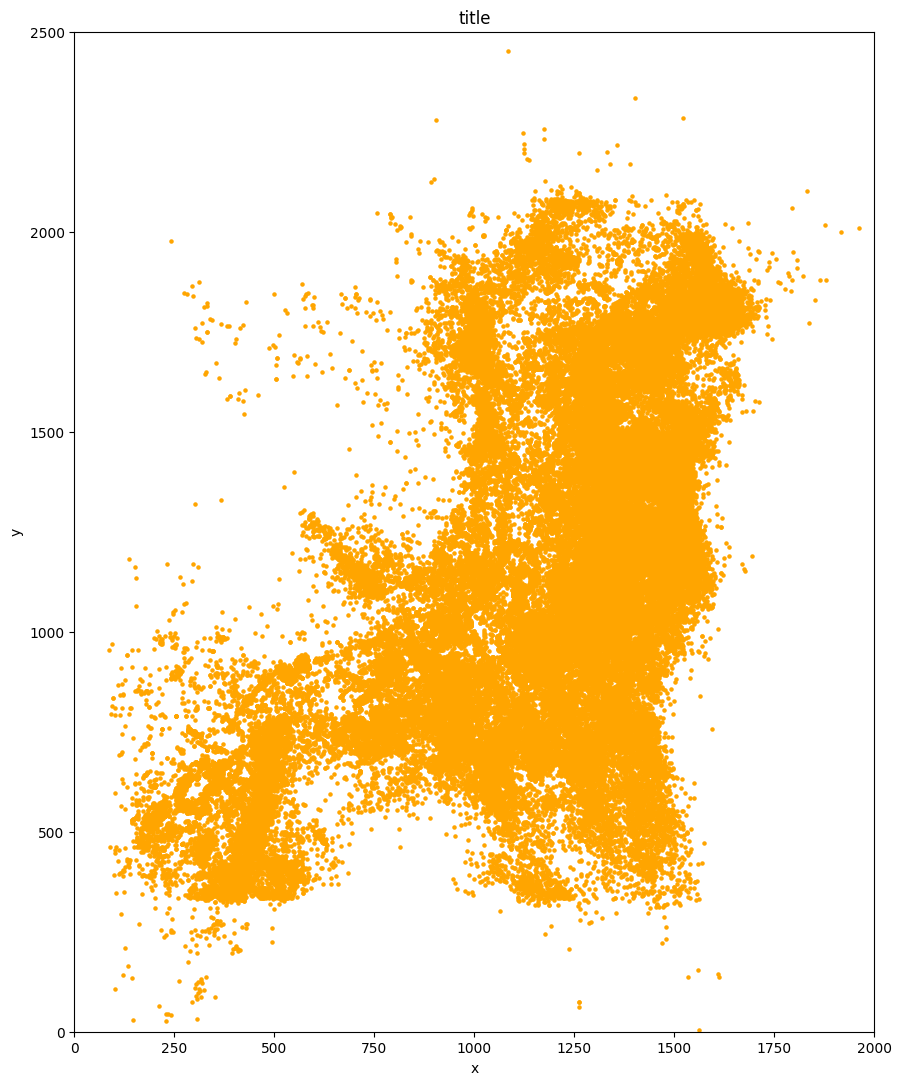

In [7]:
fig = plt.figure(figsize=(10, 12.5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
plt.axis([0, 2000, 0, 2500])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('title')

plt.show()

#### Let's calculate how many days passed from 01/01/1990 to the i-th earthquake

In [8]:
time_massive = np.zeros (data.shape[0])

d_0 = dt.date (data['year'][0], data['month'][0], data['date'][0])
for i in tqdm(range (data.shape[0])):
    d_i = dt.date (data['year'][i], data['month'][i], data['date'][i])
    time_massive[i] = (d_i - d_0).days
    
data['time'] = time_massive

  0%|          | 0/247474 [00:00<?, ?it/s]

## Splitting dataset by days and cells

In [9]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500

N_CELLS_HOR = 200
N_CELLS_VER = 250

In [10]:
def create_celled_data(n_cells_hor, n_cells_ver, indicies):
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 1, n_cells_hor, n_cells_ver])

    cell_size_hor = (RIGHT_BORDER - LEFT_BORDER) / n_cells_hor
    cell_size_ver = (UP_BORDER    - DOWN_BORDER) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > LEFT_BORDER)  and
            (data['x'][i] < RIGHT_BORDER) and
            (data['y'][i] > DOWN_BORDER)  and
            (data['y'][i] < UP_BORDER)):
            
            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['class'][i]
    print (celled_data.shape)
    return celled_data

In [11]:
celled_data = create_celled_data(N_CELLS_HOR, N_CELLS_VER, range (data.shape[0]))

  0%|          | 0/247474 [00:00<?, ?it/s]

torch.Size([9591, 1, 200, 250])


In [12]:
freq_map = (celled_data>0).float().mean(dim=0)

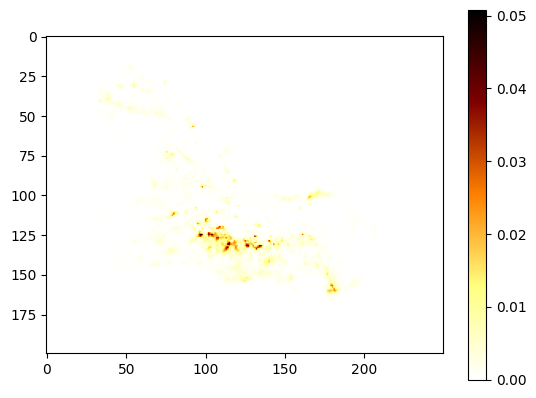

In [13]:
plt.imshow (freq_map.squeeze(0), cmap=plt.cm.afmhot_r)
plt.colorbar()

In [14]:
torch.save(celled_data,
           "Data/celled_data_" +
           str(N_CELLS_HOR) +
           "x" +
           str(N_CELLS_VER))

torch.save(freq_map,
           "Data/freq_map_" +
           str(N_CELLS_HOR) +
           "x" +
           str(N_CELLS_VER))